In [1]:
from os import environ as ENV

import pandas as pd
import bct
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

In [3]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons]
coords = get_coords(record).loc[sig_neurons]

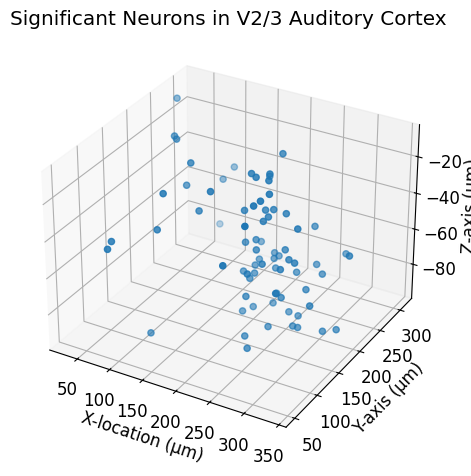

In [253]:
# Correlation mapping of significant neurons in V2/3 Auditory Cortex
plt.rcParams['font.size'] = 12
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(coords['x'], coords['y'], coords['z'])
ax.set_xlabel('X-location (µm)')
ax.set_ylabel('Y-axis (µm)')
ax.set_zlabel('Z-axis (µm)')
ax.set_title('Significant Neurons in V2/3 Auditory Cortex')
plt.tight_layout()
plt.savefig(ENV['PWD'] + '/figures/sig_neurons_cortex.png', dpi=300)
plt.show()

In [5]:
# load data
quantum_fidelity_amp_qft_df = pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed_qft.csv', index_col=0)
quantum_fidelity_amp_qft_df.columns = [int(i) for i in quantum_fidelity_amp_qft_df.columns]
quantum_fidelity_amp_df = pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed.csv', index_col=0)
quantum_fidelity_amp_df.columns = [int(i) for i in quantum_fidelity_amp_df.columns]
quantum_fidelity_ang_df = pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_angle_embed.csv', index_col=0)
quantum_fidelity_ang_df.columns = [int(i) for i in quantum_fidelity_ang_df.columns]
corrs_df = pd.read_csv(ENV['PWD'] + '/data/classical-correlations.csv', index_col=0)
corrs_df.columns = [int(i) for i in corrs_df.columns]
euclidean_dist_df = pd.read_csv(ENV['PWD'] + '/data/euclidean_distance.csv', index_col=0)
euclidean_dist_df.columns = [int(float(i)) for i in euclidean_dist_df.columns]


In [6]:
def rescale(x):
    flat = x.to_numpy().flatten()
    return (flat - np.min(flat)) / (np.max(flat) - np.min(flat))

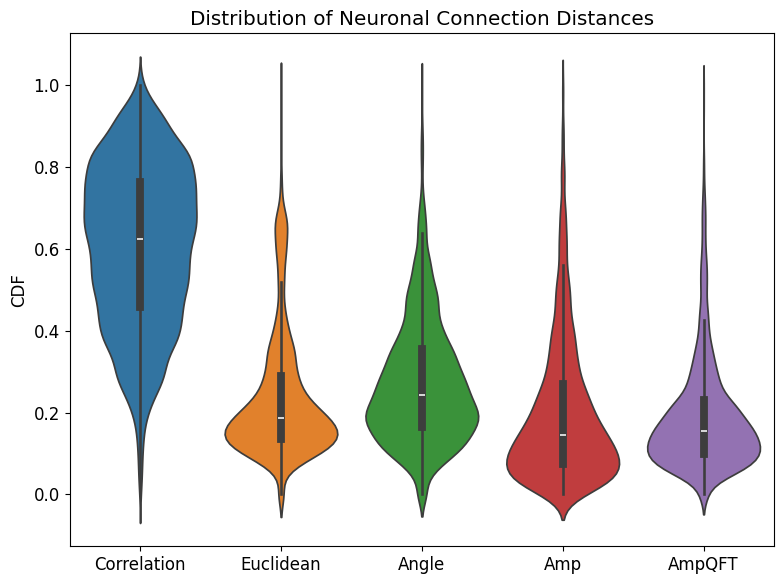

In [254]:
plt.rcParams['font.size'] = 12

plt.close()
# Plot Distribution of Neuronal Connection Distances
plt.figure(figsize=(8, 6))

data_dict = {
    'Correlation': rescale(corrs_df), # add 1 to make corrs non-negative
    'Euclidean': rescale(euclidean_dist_df),
    'Angle': rescale(1-quantum_fidelity_ang_df),
    'Amp': rescale(1-quantum_fidelity_amp_df),
    'AmpQFT': rescale(1-quantum_fidelity_amp_qft_df),
}
sns.violinplot(data_dict)

# plt.xlabel("Metric name")
plt.ylabel("CDF")
plt.title("Distribution of Neuronal Connection Distances")
plt.tight_layout()
plt.show()

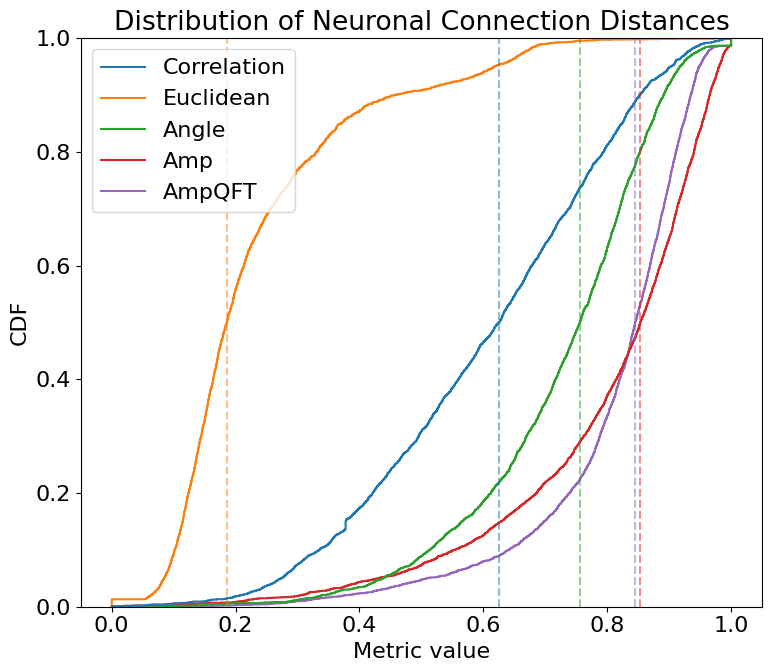

In [264]:
plt.rcParams['font.size'] = 16

plt.close()
# Plot Distribution of Neuronal Connection Distances
plt.figure(figsize=(8, 7))
default_palette = sns.color_palette()
first_five_colors = default_palette[:5]

data_dict = {
    'Correlation': rescale(corrs_df), # add 1 to make corrs non-negative
    'Euclidean': rescale(euclidean_dist_df),
    'Angle': rescale(quantum_fidelity_ang_df),
    'Amp': rescale(quantum_fidelity_amp_df),
    'AmpQFT': rescale(quantum_fidelity_amp_qft_df),
}
sns.ecdfplot(data_dict)
i=0
for metric, data in data_dict.items():
    median_x = np.median(data)
    plt.axvline(median_x, linestyle='--', alpha=0.5, c=default_palette[i])
    i+=1

plt.xlabel("Metric value")
plt.ylabel("CDF")
plt.title("Distribution of Neuronal Connection Distances")
handles, labels = ax.get_legend_handles_labels()

plt.tight_layout()
plt.show()

In [9]:
import itertools

In [10]:
def make_graph(dist_matrix):
    # Minimum Spanning Tree (MST)
    G = nx.Graph()
    for i in dist_matrix.index:
        G.add_node(i, pos=coords.loc[i])
    for (i, j) in itertools.combinations(dist_matrix.index, 2):
        G.add_edge(i, j, weight=dist_matrix.loc[i][j])
    return G

In [11]:
# prepare matrices

In [12]:
import networkx as nx
# draw graphs


In [13]:
# MST of fidelity is maximize 1-fidelity
matrices = [
    corrs_df,
    euclidean_dist_df,
    1-quantum_fidelity_ang_df,
    1-quantum_fidelity_amp_df,
    1-quantum_fidelity_amp_qft_df,
]

In [14]:
graphs = [make_graph(i) for i in matrices]
graph_labels = [ "Correlation", "Euclidean", "Angle", "Amp", "AmpQFT",]

In [15]:
def remove_edges_under_percentile(G, percentile):
    new_G = G.copy()
    # Get edge weights
    edge_weights = [G[u][v]['weight'] for u, v in G.edges() if G[u][v]['weight'] is not None]

    # Calculate percentile
    threshold = np.percentile(edge_weights, percentile)

    # Identify and remove edges
    edges_to_remove = [(u, v) for u, v in new_G.edges() if new_G[u][v]['weight'] < threshold]
    new_G.remove_edges_from(edges_to_remove)

    return new_G

In [16]:
# threshold graphs not with bctpy but with networkx
# import bct
msts = [nx.minimum_spanning_tree(g) for g in graphs]
threshold_95 = [remove_edges_under_percentile(g, 95) for g in graphs]
threshold_90 = [remove_edges_under_percentile(g, 90) for g in graphs]


In [17]:
def average_degree(G):
    return 2 * G.number_of_edges() / G.number_of_nodes()

In [18]:
# need to threshold graphs such that the average degree is >2 but less than the square of the number of neurons
# region of intermediate sparsity
# https://www.nature.com/articles/s41467-019-08746-5
76**0.5

8.717797887081348

In [19]:
[average_degree(g) for g in msts] # < 2


[1.9736842105263157,
 1.9736842105263157,
 1.9736842105263157,
 1.9736842105263157,
 1.9736842105263157]

In [20]:
[average_degree(g) for g in threshold_95] # < 2

[3.763157894736842,
 3.763157894736842,
 3.763157894736842,
 3.763157894736842,
 3.763157894736842]

In [21]:
[average_degree(g) for g in threshold_90] # < 2


[7.5, 7.5, 7.5, 7.5, 7.5]

In [22]:
# sparsity conditions satisfied

# Plotting networks

## 2D

In [23]:
def plot_graph_circular(G, title, ax):
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=10, node_color='royalblue')
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=weights.min(), vmax=weights.max())
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, alpha=0.6)

    ax.set_title(title, fontsize=20)
    ax.set_frame_on(False)
    ax.set_axis_off()


def plot_2d_wrapper(graphs, suffix):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    for i in range(len(graphs)):
        plot_graph_circular(graphs[i], graph_labels[i], axes[i])

    # Hide the last unused subplot
    axes[-1].axis('off')

    plt.suptitle(f'2D functional networks ({suffix})', fontsize=20)
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/network-2d-{suffix}.png', dpi=300)


plt.close()
for graph_list, suffix in zip([msts, threshold_95, threshold_90, threshold_85], ['MST', 'top 5%', 'top 10%', 'top 15%']):
    plot_2d_wrapper(graph_list, suffix)
plt.show()


In [265]:
def plot_2d_wrapper_grid(graph_lists, graph_labels, suffixes):
    plt.rcParams['font.size'] = 16
    
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    j = 0
    for graphs, sfx in zip(graph_lists, suffixes):
        for i in range(len(graphs)):
            plot_graph_circular(graphs[i], graph_labels[i], axes[j])
            if j >= 5:
                axes[j].set_title('') # hide title of columns
            if j % 5 == 0:
                axes[j].set_axis_on()
                axes[j].set_frame_on(False)
                axes[j].set_ylabel(sfx, fontsize=20, rotation=0, ha='right')
            j+=1

    # Hide the last unused subplot
    # axes[-1].axis('off')

    # plt.suptitle(f'2D functional networks ({suffix})', fontsize=20)
    plt.suptitle('2D functional networks', fontsize=28)
    # fig.subplots_adjust(top=0.93)  # move suptitle down
    
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/network-2d-grid.png', dpi=300)


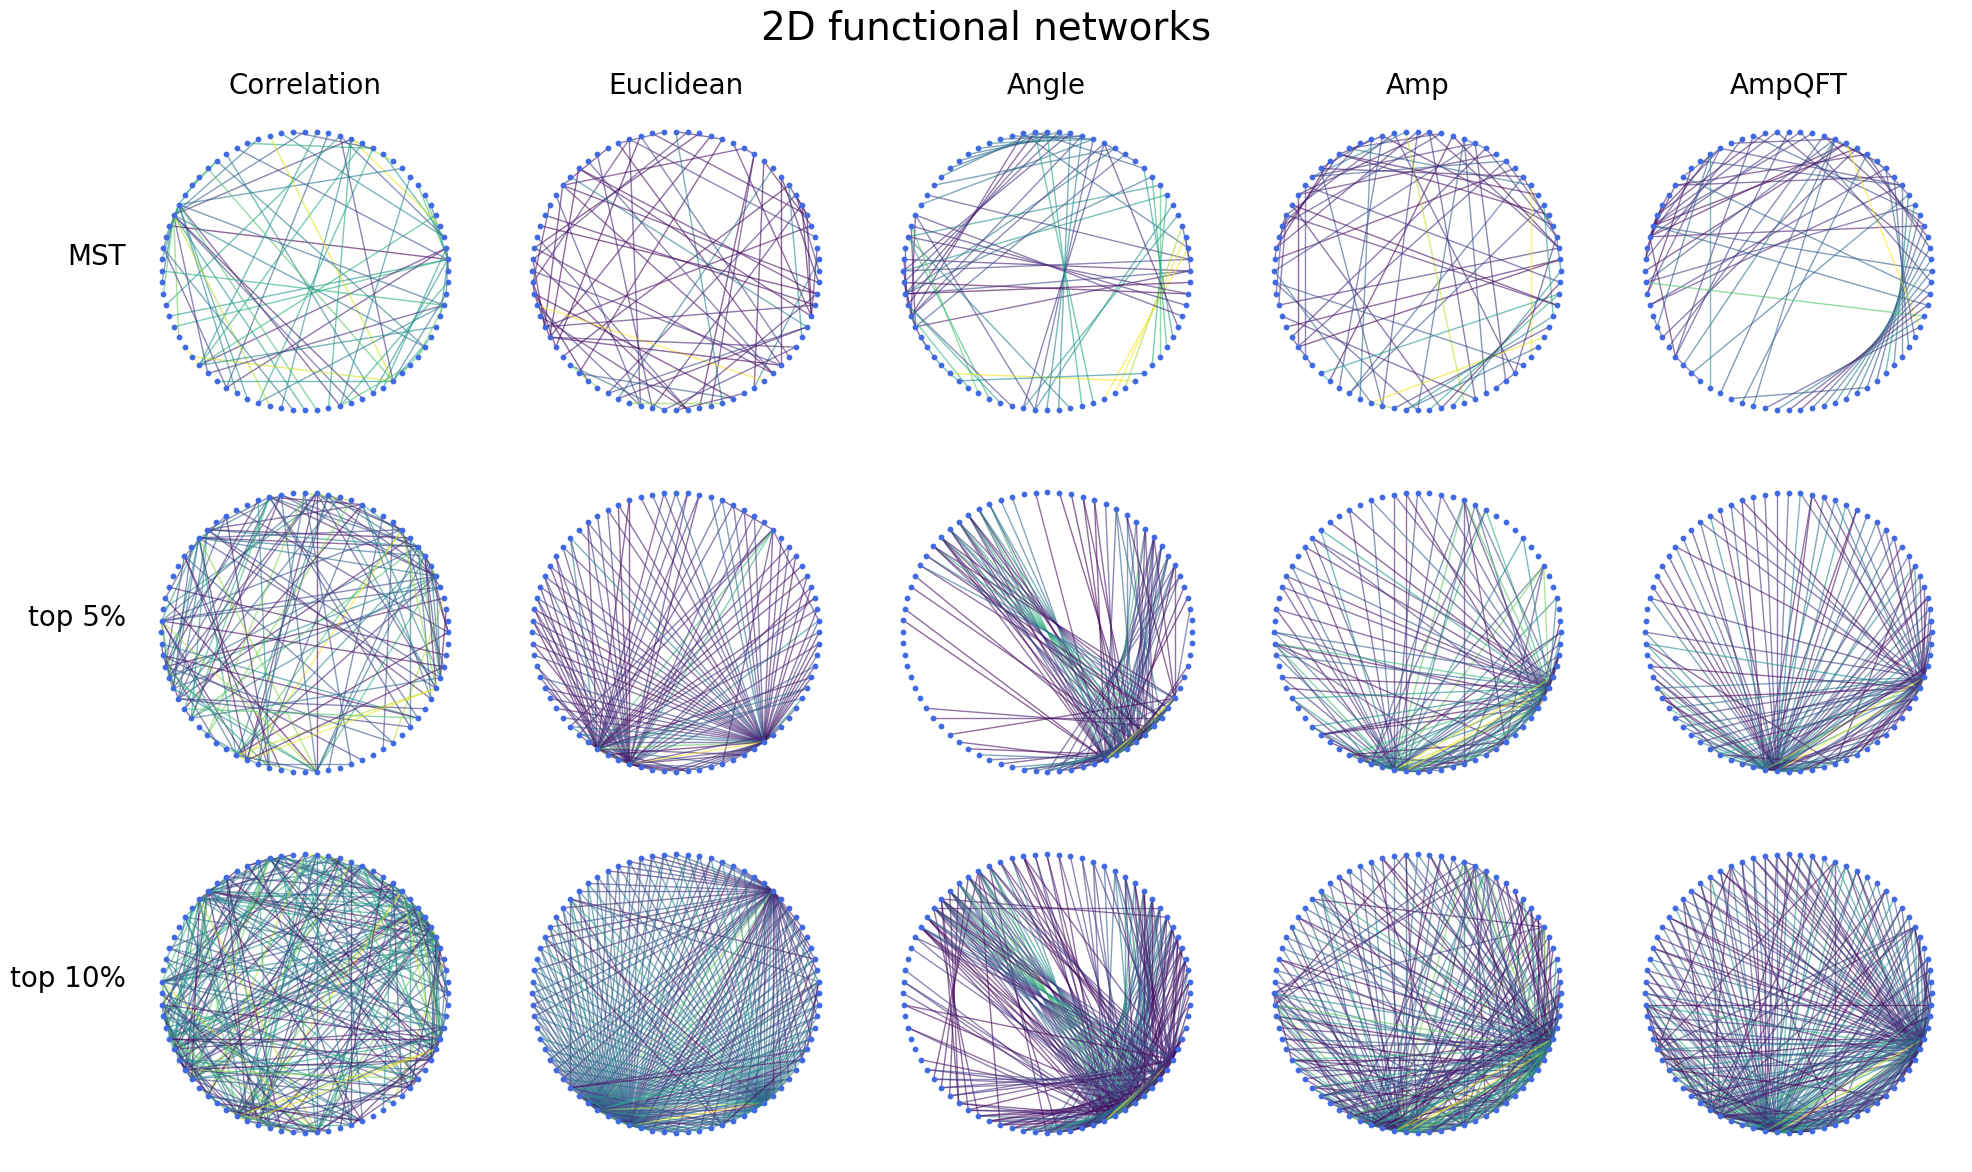

In [266]:
plot_2d_wrapper_grid([msts, threshold_95, threshold_90],
                     graph_labels,
                     ['MST', 'top 5%', 'top 10%'])

## 3D

In [26]:
# Plot the MSTs

def plot_graph_3d(G, title, ax, node_color='royalblue'):
    plt.rcParams['font.size'] = 16
    
    pos = nx.get_node_attributes(G, 'pos')
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=weights.min(), vmax=weights.max())

    for u, v in G.edges():
        x = [pos[u]['x'], pos[v]['x']]
        y = [pos[u]['y'], pos[v]['y']]
        z = [pos[u]['z'], pos[v]['z']]
        weight = G[u][v]['weight']
        edge_color = cmap(norm(weight))
        ax.plot(x, y, z, color=edge_color, alpha=0.6)

    xs, ys, zs = zip(*pos.values())
    # print(xs, ys, zs)
    ax.scatter(xs, ys, zs, s=10, color=node_color)
    ax.set_title(title, fontsize=20)
    # ax.set_axis_off()
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('z')

def plot_3d_wrapper(graphs, suffix):

    plt.close()

    fig = plt.figure(figsize=(16, 10))
    for i in range(5):
        plot_graph_3d(graphs[i], graph_labels[i], fig.add_subplot(2, 3, i+1, projection='3d'))

    plt.suptitle(f'3D functional networks ({suffix})', fontsize=20)
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/network-3d-{suffix}.png', dpi=300)

    plt.show()

for graph_list, suffix in zip([msts, threshold_95, threshold_90, threshold_85], ['MST', 'top 5%', 'top 10%', 'top 15%']):
    plot_3d_wrapper(graph_list, suffix)

In [168]:
def plot_3d_wrapper_grid(graph_lists, graph_labels, suffixes):

    plt.close()

    fig, axes = plt.subplots(3, 5, figsize=(22, 12), subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    j = 0
    for graphs, sfx in zip(graph_lists, suffixes):
        for i in range(len(graphs)):
            # print(j)
            plot_graph_3d(graphs[i], graph_labels[i], axes[j]) # , fig.add_subplot(2, 3, i+1, projection='3d'))
            if j >= 5:
                axes[j].set_title('') # hide title of columns

            j+=1

    plt.suptitle(f'3D functional networks', fontsize=28)
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/network-3d-grid.png', dpi=300)

    plt.show()

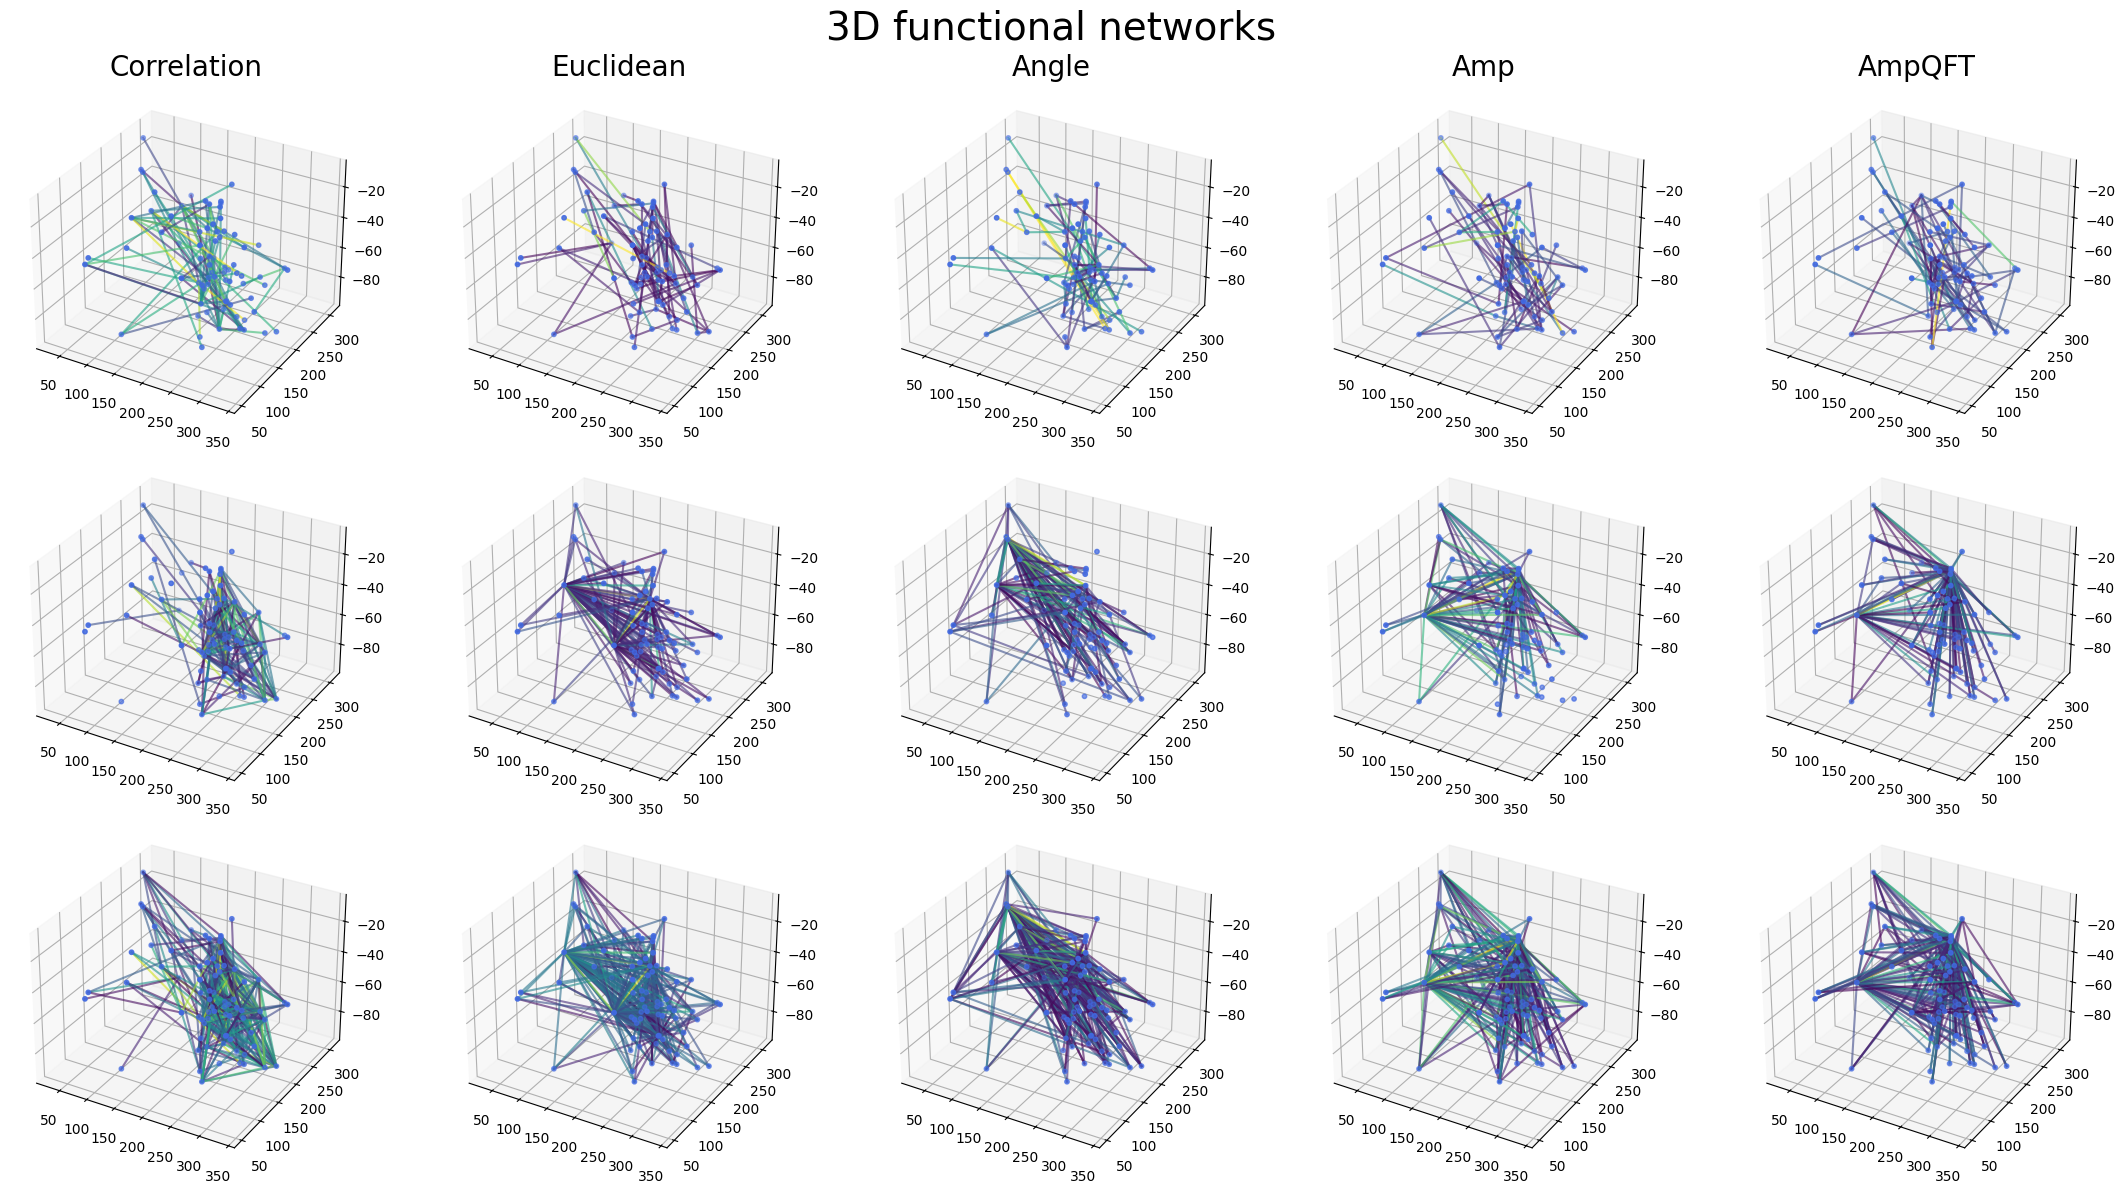

In [169]:
plot_3d_wrapper_grid([msts, threshold_95, threshold_90],
                     graph_labels,
                     ['MST', 'top 5%', 'top 10%'])

# Difference Quantification

### Jaccard Differences, DeltaCon, and QuantumJSD and more

- Jaccard distance = intersection over union, how much they overlap
- DeltaCon - ??? (https://arxiv.org/abs/1304.4657)
- Portrait divergence - graph invariant metric (https://arxiv.org/abs/1804.03665)
- QuantumJSD = spectral entropy


In [326]:
from netrd.distance import DeltaCon, QuantumJSD, PortraitDivergence
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def jaccard_distance(G1, G2):
    E1 = set(G1.edges())
    E2 = set(G2.edges())
    intersection = len(E1 & E2)
    union = len(E1 | E2)
    return 1 - (intersection / union if union > 0 else 0)

results = []

for label, matrix in zip(graph_labels, matrices):
    # Build base graph
    G_full = make_graph(matrix)

    # Generate three subgraph variants
    G_mst = nx.minimum_spanning_tree(G_full)
    G_top5 = remove_edges_under_percentile(G_full, 95)
    G_top10 = remove_edges_under_percentile(G_full, 90)
    def nodes_to_remove(G):
        return [node for node in G.nodes() if G.degree(node) == 0] #  and G.out_degree(node) == 0]
    # Remove nodes without ingoing / outgoing connections
    # G_mst.remove_nodes_from(nodes_to_remove(G_mst))
    # G_top5.remove_nodes_from(nodes_to_remove(G_top5))
    # G_top10.remove_nodes_from(nodes_to_remove(G_top10))

    # All pairs to compare
    graph_pairs = [
        ("MST vs Top5", G_mst, G_top5),
        ("MST vs Top10", G_mst, G_top10),
        ("Top5 vs Top10", G_top5, G_top10),
    ]

    # Calculate Jaccard, Deltacon, and QuantumJSD
    for comp_name, G1, G2 in graph_pairs:
        try:
            jacc = jaccard_distance(G1, G2)
            deltacon = DeltaCon().dist(G1, G2)
            qjsd = QuantumJSD().dist(G1, G2)
            portraitd = PortraitDivergence().dist(G1, G2)
        except Exception as e:
            print(f"Error comparing {label} - {comp_name}: {e}")
            jacc, deltacon, qjsd, portraitd, edit_dist = None, None, None, None, None

        results.append({
            "Graph Type": label,
            "Comparison": comp_name,
            "Jaccard": jacc,
            "DeltaCon": deltacon,
            "QuantumJSD": qjsd,
            "PortraitDivergence": portraitd,
        })

# Place resutls in data frame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Graph Type", "Comparison"])

# Needed to quickly split comparison column
clean_df = results_df.copy()
clean_df[['Network1', 'Network2']] = clean_df['Comparison'].str.split(' vs ', expand=True)
clean_df = clean_df[['Graph Type', 'Network1', 'Network2', 'Jaccard', 'DeltaCon', 'QuantumJSD', 'PortraitDivergence']]

print(clean_df.round(3))

/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/netrd/distance/deltacon.py:105: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum(np.square(np.sqrt(X) - np.sqrt(Y))))
/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)


     Graph Type Network1 Network2  Jaccard  DeltaCon  QuantumJSD  \
10          Amp      MST    Top10    1.000     3.726       0.237   
9           Amp      MST     Top5    1.000     3.168       0.179   
11          Amp     Top5    Top10    0.498     2.070       0.110   
13       AmpQFT      MST    Top10    1.000     3.576       0.223   
12       AmpQFT      MST     Top5    1.000     3.137       0.172   
14       AmpQFT     Top5    Top10    0.498     1.581       0.112   
7         Angle      MST    Top10    1.000     2.394       0.272   
6         Angle      MST     Top5    1.000     1.919       0.208   
8         Angle     Top5    Top10    0.498     1.361       0.108   
1   Correlation      MST    Top10    1.000       NaN       0.277   
0   Correlation      MST     Top5    1.000       NaN       0.199   
2   Correlation     Top5    Top10    0.498     3.547       0.127   
4     Euclidean      MST    Top10    1.000     4.467       0.193   
3     Euclidean      MST     Top5    1.000     4

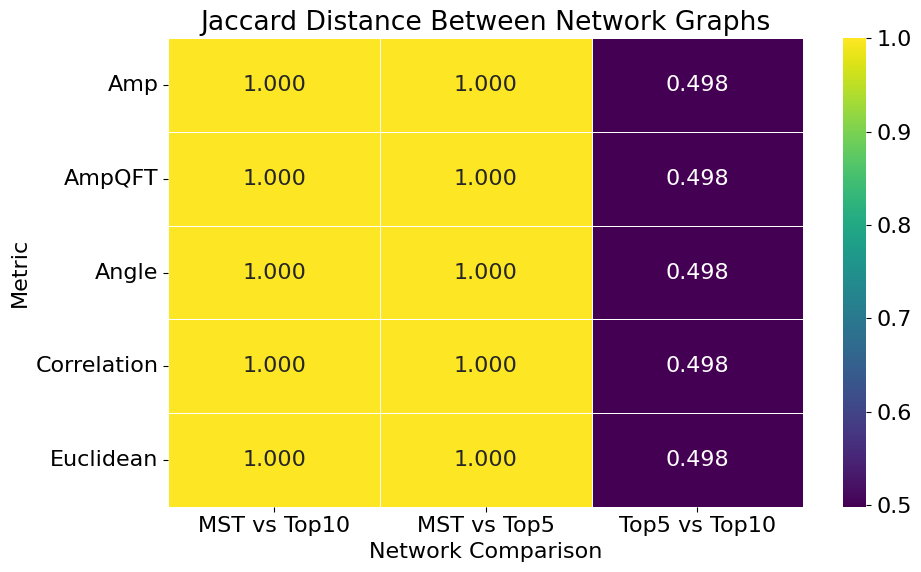

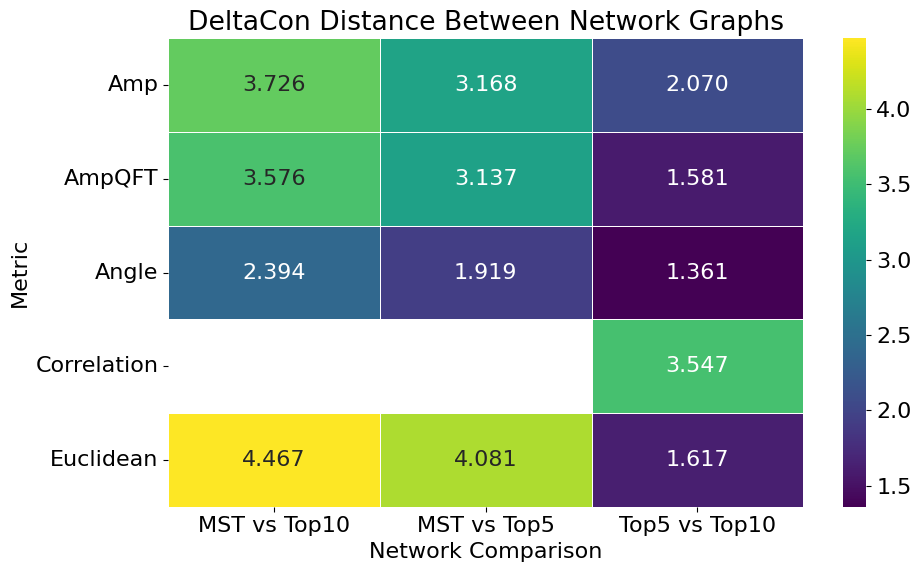

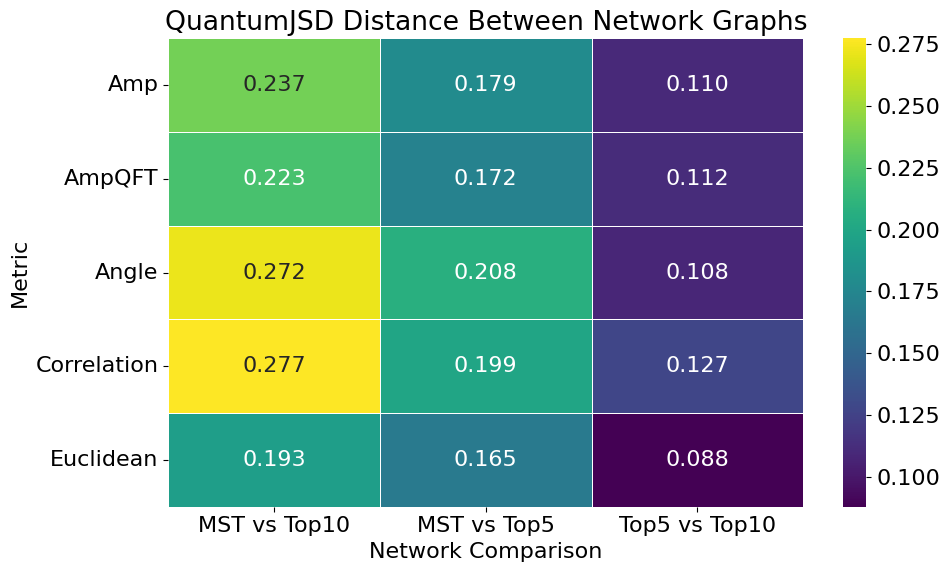

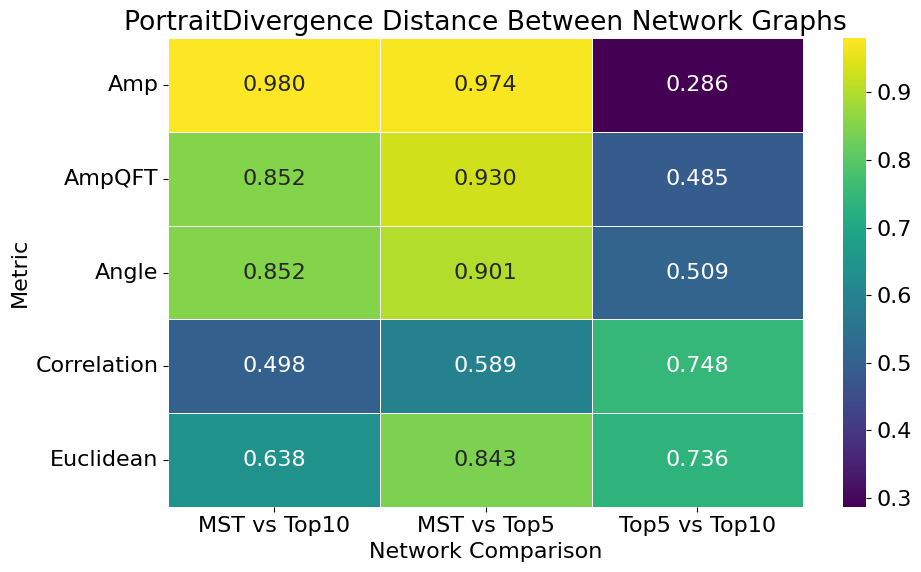

In [352]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16
# Loop through each metric and plot a heatmap
metrics = ['Jaccard', 'DeltaCon', 'QuantumJSD', 'PortraitDivergence']
for metric in metrics:
    # Pivot table: rows = Graph Type, columns = Comparison (Network1-Network2)
    pivot_df = clean_df.copy()
    pivot_df['Comparison'] = pivot_df['Network1'] + ' vs ' + pivot_df['Network2']
    heatmap_df = pivot_df.pivot(index='Graph Type', columns='Comparison', values=metric)

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
    plt.title(f"{metric} Distance Between Network Graphs")
    plt.xlabel("Network Comparison")
    plt.ylabel("Metric")
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/graph-distance-{metric}.png', dpi=300)
    plt.show()


# Rent's Analysis

In [29]:
import numpy as np
import statsmodels.api as sm
from scipy import stats

def rentian_scaling_linreg(adj_matrix, coords, n=300, threshold=0.9, confidence=0.95):
    """
    Compute Rentian scaling slope and its confidence interval.

    Parameters:
    adj_matrix (numpy array): Adjacency matrix of the network.
    coords (numpy array): Coordinates of the nodes in the network.
    n (int, optional): Number of iterations for Rentian scaling. Defaults to 300.
    threshold (float, optional): Threshold for binarizing the adjacency matrix. Defaults to 0.9.
    confidence (float, optional): Confidence level for the interval. Defaults to 0.95.

    Returns:
    tuple: Computed slope and its confidence interval.
    """

    # Binarize the adjacency matrix
    # sc_matrix = adj_matrix
    # adj_matrix = (sc_matrix >= threshold).astype(int)
    # np.fill_diagonal(adj_matrix, 0)

    # Run Rentian scaling
    N, E = rentian_scaling(adj_matrix, coords, n=n)
    mask = (N > 0) & (E > 0)
    log_N = np.log10(N[mask]).reshape(-1, 1) #[mask]).reshape(-1, 1)
    log_E = np.log10(E[mask]).reshape(-1, 1) #[mask]).reshape(-1, 1)

    # Add a constant (intercept) to the independent value
    X = sm.add_constant(log_N)

    # Linear regression
    model = sm.OLS(log_E, X).fit()
    slope = model.params[1]
    intercept = model.params[0]
    r2 = model.rsquared

    # Confidence interval for the slope
    stderr = model.bse[1]
    interval = stats.t.ppf((1 + confidence) / 2, len(log_E) - 2) * stderr
    ci = (slope - interval, slope + interval)

    return slope, (slope, slope - interval, slope + interval), log_N, log_E, intercept, r2, ci


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_linear_regression(log_N, log_E, slope, intercept, r2, ax=None, confidence=0.95):
    if ax is None:
        ax = plt.gca()

    # Plot the data points
    ax.scatter(log_N, log_E, s=20, alpha=0.9, color='gray') # , label='Samples')

    # Plot the fitted line
    log_N_fit = np.linspace(log_N.min(), log_N.max(), 100).reshape(-1, 1)
    log_E_fit = slope * log_N_fit + intercept
    ax.plot(log_N_fit, log_E_fit, color='crimson', linewidth=2,
             label=f'Fit: slope = {slope:.2f}, $R^2$ = {r2:.2f}')

    ax.set_xlabel(r"log$_{10}$(Number of nodes in cube)")
    ax.set_ylabel(r"log$_{10}$(Number of crossing edges)")
    # ax.set_title("Linear Regression")
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(loc='lower right')


In [275]:
def plot_rentian_scaling_wrapper_grid(inputs, graph_labels, suffixes):
    plt.rcParams['font.size'] = 16
    
    plt.close()
    intervals = []
    fig, axes = plt.subplots(2, 5, figsize=(30, 13))
    axes = axes.flatten()
    j = 0
    for input_, sfx in zip(inputs, suffixes):
        for i in range(len(input_)):
            adj_matrix = input_[i]
            slope, interval, log_N, log_E, intercept, r2, ci = rentian_scaling_linreg(adj_matrix, coords.to_numpy())
            plot_linear_regression(log_N, log_E, slope, intercept, r2, ax=axes[j])
            # axes[j].set_title(j)
            if j % 5 != 0:
                axes[j].set_ylabel('')
            if j < 5:
                axes[j].set_xlabel('')
                axes[j].set_title(graph_labels[i], fontsize=20)
            j += 1
            intervals.append(interval)

    plt.suptitle(f'Rentian Scaling', fontsize=28)
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/rentian-scaling-grid.png', dpi=300)

    plt.show()
    return intervals

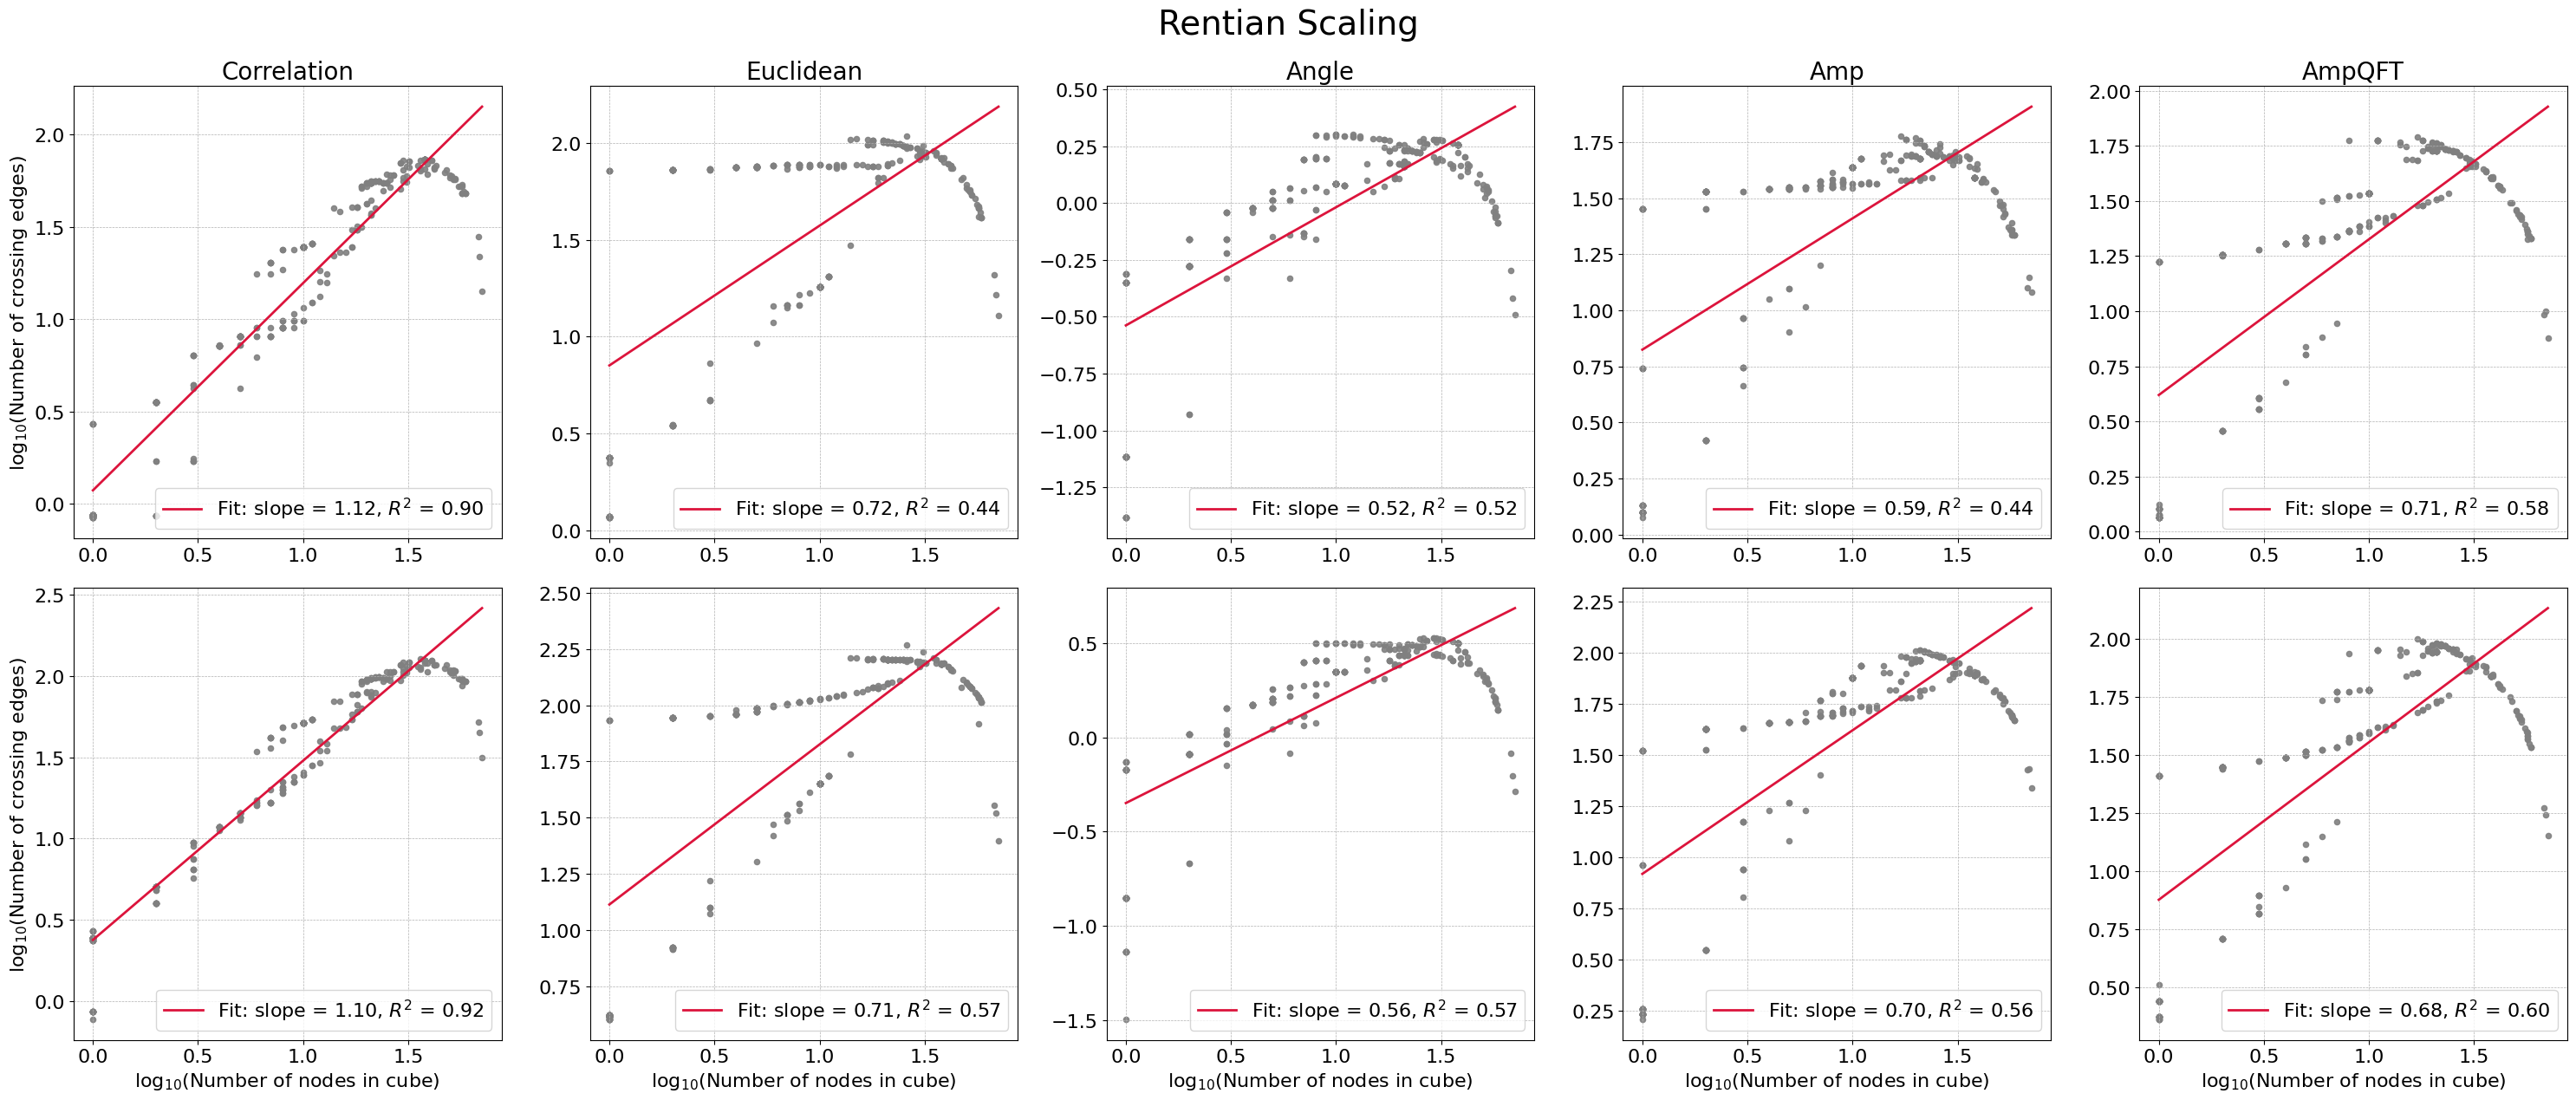

In [276]:
intervals = plot_rentian_scaling_wrapper_grid(
    [
        # [nx.adjacency_matrix(m) for m in msts],  # gives 0-sized array, no analysis possible
        [nx.adjacency_matrix(m) for m in threshold_95],
        [nx.adjacency_matrix(m) for m in threshold_90]
    ],
    graph_labels,
    ['top 5%', 'top 10%'],
)

In [33]:
rent_exps_df = pd.DataFrame(intervals, columns=['linear $r^2$', 'low', 'high'])

In [34]:
rent_exps_df['metric'] = graph_labels*2 # string type
rent_exps_df['threshold'] = ['5%'] * 5 + ['10%'] * 5

In [35]:
# verify that rentian scaling is achieved
threshold_95_power_law_r2 = [is_rentian_scaling(m, coords, M=300) for m in [nx.adjacency_matrix(m) for m in threshold_95]]
threshold_95_power_law_r2 = [x[0] for x in threshold_95_power_law_r2]

Power law R^2: 0.75
Exponential law R^2: -7197035586004035405917192192.00
Rentian scaling achieved
Power law R^2: 0.25
Exponential law R^2: -3613735931478667795110035456.00
Rentian scaling achieved
Power law R^2: 0.45
Exponential law R^2: -14530107453973140438213906661376.00
Rentian scaling achieved
Power law R^2: 0.33
Exponential law R^2: -17853928696223786303255216128.00
Rentian scaling achieved
Power law R^2: 0.41
Exponential law R^2: -13953289324874884201228271616.00
Rentian scaling achieved


In [36]:
# verify that rentian scaling is achieved
threshold_90_power_law_r2 = [is_rentian_scaling(m, coords, M=300) for m in [nx.adjacency_matrix(m) for m in threshold_90]]
threshold_90_power_law_r2 = [x[0] for x in threshold_90_power_law_r2]

Power law R^2: 0.78
Exponential law R^2: -2402649810382177109280817152.00
Rentian scaling achieved
Power law R^2: 0.50
Exponential law R^2: -1518089451590908494127038464.00
Rentian scaling achieved
Power law R^2: 0.50
Exponential law R^2: -4643329644346151078825102934016.00
Rentian scaling achieved
Power law R^2: 0.48
Exponential law R^2: -5084142999678317323094065152.00
Rentian scaling achieved
Power law R^2: 0.43
Exponential law R^2: -5207976907222617876470956032.00
Rentian scaling achieved


Text(0.5, 1.0, 'Rent exponent')

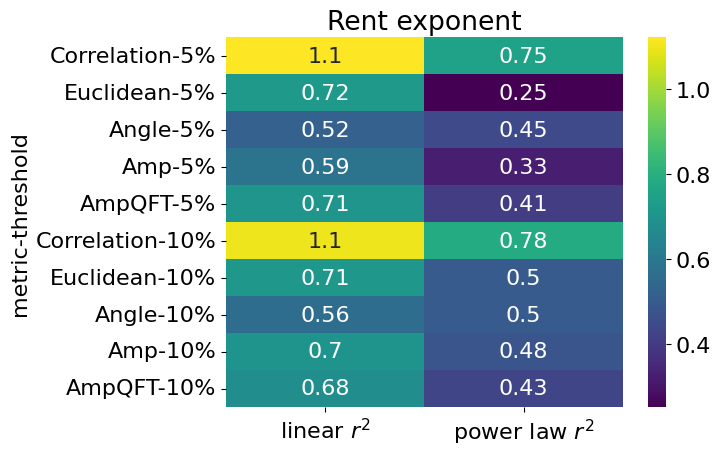

In [332]:
plt.rcParams['font.size'] = 16

rent_exp_df_for_plot = rent_exps_df.set_index(['metric', 'threshold']).drop(columns=['low', 'high'])
rent_exp_df_for_plot['power law $r^2$'] = threshold_95_power_law_r2 + threshold_90_power_law_r2
sns.heatmap(rent_exp_df_for_plot, annot=True, cmap='viridis')
plt.title('Rent exponent')

# Small world propensity

In [38]:
rng = np.random.default_rng(42)

In [39]:
import small_world_propensity as swp

In [48]:
ms = [nx.adjacency_matrix(m).toarray() for m in threshold_95 + threshold_90]

In [287]:
its_a_small_world_after_all = swp.small_world_propensity(ms)

  0%|          | 0/10 [00:00<?, ?it/s]/home/user/work/quadrigems/notebooks/../small_world_propensity.py:59: RuntimeWarning: divide by zero encountered in divide
  path_matrix = csgraph.shortest_path(1/W, directed=False, unweighted=False)
/home/user/work/quadrigems/notebooks/../small_world_propensity.py:149: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.arctan(delta_L / delta_C)
100%|██████████| 10/10 [00:00<00:00, 256.46it/s]


In [288]:
its_a_small_world_after_all['metric'] = graph_labels*2 # string type
its_a_small_world_after_all['threshold'] = ['5%'] * 5 + ['10%'] * 5

In [289]:
its_a_small_world_after_all = its_a_small_world_after_all.set_index(['metric', 'threshold'])
its_a_small_world_after_all

Network C  Network L        ΔC        ΔL       SWP  \
metric      threshold                                                       
Correlation 5%          0.253651   1.483359  0.251841  0.000000  0.821921   
Euclidean   5%          0.360653   2.886166  0.000000  0.000000  1.000000   
Angle       5%          0.131087   2.227856  0.507391  0.000000  0.641220   
Amp         5%          0.009654   1.607041  1.000000  0.000000  0.292893   
AmpQFT      5%          0.049540   3.167952  0.863054  0.000000  0.389729   
Correlation 10%         0.323932   3.473011  0.386529  0.178191  0.699038   
Euclidean   10%         0.504831   2.840966  0.000000  0.000000  1.000000   
Angle       10%         0.289158   2.900381  0.178708  0.000000  0.873635   
Amp         10%         0.037695   3.320706  1.000000  0.000000  0.292893   
AmpQFT      10%         0.168369   3.244434  0.509951  0.000000  0.639410   

                              α         δ  Regular C  Random C  Regular L  \
metric      threshold                                                       
Correlation 5%         0.000000 -1.000000   0.326602  0.036931  12.338172   
Euclidean   5%              NaN       NaN   0.248787  0.032031  16.361561   
Angle       5%         0.000000 -1.000000   0.243780  0.021676  17.460640   
Amp         5%         0.000000 -1.000000   0.259663  0.014672  16.648958   
AmpQFT      5%         0.000000 -1.000000   0.227696  0.021271  19.146260   
Correlation 10%        0.431966 -0.450004   0.481442  0.073943   6.937705   
Euclidean   10%             NaN       NaN   0.354400  0.063285  10.121685   
Angle       10%        0.000000 -1.000000   0.340143  0.054842  10.574508   
Amp         10%        0.000000 -1.000000   0.348593  0.050018  11.046816   
AmpQFT      10%        0.000000 -1.000000   0.299183  0.042661  13.467571   

                       Random L  
metric      threshold            
Correlation 5%         3.274678  
Euclidean   5%         4.045867  
Angle       5%         5.125544  
Amp         5%         4.380983  
AmpQFT      5%         4.943203  
Correlation 10%        2.721770  
Euclidean   10%        3.669381  
Angle       10%        3.819741  
Amp         10%        3.799409  
AmpQFT      10%        4.394205

In [290]:
its_a_small_world_after_all = its_a_small_world_after_all[['SWP']]

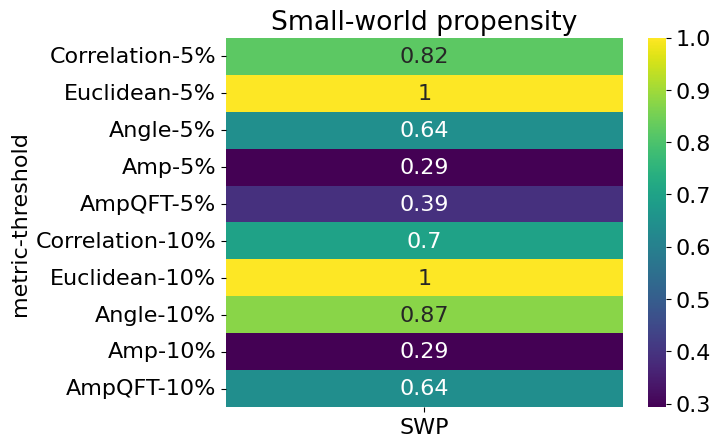

In [335]:
plt.rcParams['font.size'] = 16
sns.heatmap(its_a_small_world_after_all[['SWP']], annot=True, cmap='viridis')
# plt.title("It's a small world after all")
plt.title("Small-world propensity")
plt.show()

# Average and nearest neighbor distances



In [142]:
graphs

In [143]:
[msts, threshold_95, threshold_90]

[[<networkx.classes.graph.Graph at 0x7f0018969350>,

In [144]:
from tqdm.notebook import tqdm

In [145]:
def calculate_distances(G):
    # Extract node coordinates
    nodes = list(G.nodes)
    # Calculate nearest and average neighbor distance for each node
    nearest_nn_distances = []
    average_nn_distances = []
    for node in nodes:
        neighbors = list(G.neighbors(node))
        if neighbors:
            neighbor_positions = np.array([G.nodes[neighbor]['pos'] for neighbor in neighbors])
            node_position = G.nodes[node]['pos']
            # print(node_position, neighbor_positions[0])
            distances = [np.linalg.norm(neighbor_position - node_position) for neighbor_position in neighbor_positions]
            nearest_nn_distances.append(np.min(distances))
            average_nn_distances.append(np.mean(distances))

    return np.array(nearest_nn_distances), np.array(average_nn_distances)

In [146]:
og_graphs = [make_graph(m) for m in matrices]

In [147]:
og_graphs

In [148]:
distances_calcs = [calculate_distances(g) for g in itertools.chain(*[og_graphs, msts, threshold_95, threshold_90])]

In [149]:
distances_calcs_df = pd.DataFrame(distances_calcs, columns=['Average distance', 'Nearest neighbor distance'])

In [150]:
distances_calcs_df['metric'] = graph_labels*4 # string type
distances_calcs_df['threshold'] = ['Full'] * 5 + ['MST'] * 5 + ['5%'] * 5 + ['10%'] * 5

In [151]:
distances_calcs_df

Average distance  \
0   [14.561005619929627, 27.46067068043073, 7.2932...   
1   [14.561005619929627, 27.46067068043073, 7.2932...   
2   [14.561005619929627, 27.46067068043073, 7.2932...   
3   [14.561005619929627, 27.46067068043073, 7.2932...   
4   [14.561005619929627, 27.46067068043073, 7.2932...   
5   [48.448211892298986, 38.065044184773804, 38.06...   
6   [39.30043006089769, 141.83641884636359, 92.042...   
7   [44.818940181437014, 39.42935310884425, 92.790...   
8   [75.45788305006276, 45.59871257825964, 39.6328...   
9   [164.3780509099504, 50.97205333291692, 223.459...   
10  [14.561005619929627, 92.04214091546008, 38.320...   
11  [119.11887498675847, 62.38884139282577, 120.99...   
12  [83.39021738395586, 216.71098986148164, 204.82...   
13  [64.72567852976808, 82.78770573988275, 84.3212...   
14  [85.19208048660329, 81.70214696456759, 92.0421...   
15  [14.561005619929627, 67.97268493908865, 38.320...   
16  [64.72567852976808, 58.840199059523265, 75.269...   
17  [97.82091576083317, 82.78770573988275, 61.1094...   
18  [64.72567852976808, 81.70214696456759, 87.7455...   
19  [85.19208048660329, 81.70214696456759, 72.8404...   

                            Nearest neighbor distance       metric threshold  
0   [87.55396224921974, 86.65791440045429, 97.8807...  Correlation      Full  
1   [87.55396224921974, 86.65791440045429, 97.8807...    Euclidean      Full  
2   [87.55396224921974, 86.65791440045429, 97.8807...        Angle      Full  
3   [87.55396224921974, 86.65791440045429, 97.8807...          Amp      Full  
4   [87.55396224921974, 86.65791440045429, 97.8807...       AmpQFT      Full  
5   [48.448211892298986, 83.5470419927793, 129.304...  Correlation       MST  
6   [39.30043006089769, 141.83641884636359, 92.042...    Euclidean       MST  
7   [68.96278244703873, 47.91141826165216, 158.125...        Angle       MST  
8   [125.81971865877111, 48.93555739221564, 70.253...          Amp       MST  
9   [170.27980258871492, 153.8402396165531, 236.05...       AmpQFT       MST  
10  [49.04114517479354, 92.04214091546008, 107.236...  Correlation        5%  
11  [120.55595988577568, 91.60988419728467, 151.58...    Euclidean        5%  
12  [83.39021738395586, 216.71098986148164, 204.82...        Angle        5%  
13  [89.49551367599189, 82.78770573988275, 130.512...          Amp        5%  
14  [97.69525335064326, 96.45198473331453, 108.056...       AmpQFT        5%  
15  [68.09947171118841, 78.65565867628393, 84.8913...  Correlation       10%  
16  [101.94586610043983, 102.67677353406307, 114.3...    Euclidean       10%  
17  [97.82091576083317, 154.3187842382445, 107.710...        Angle       10%  
18  [95.01087802004322, 91.89722506883727, 135.363...          Amp       10%  
19  [97.69525335064326, 96.45198473331453, 93.0857...       AmpQFT       10%

In [353]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       2.3.1
alabaster                     0.7.16
annotated-types               0.7.0
antlr4-python3-runtime        4.13.2
appdirs                       1.4.4
astunparse                    1.6.3
autograd                      1.8.0
autoray                       0.7.1
babel                         2.17.0
bctpy                         0.6.1
biom-format                   2.1.16
cachetools                    6.1.0
certifi                       2025.6.15
cffi                          1.17.1
charset-normalizer            3.4.2
click                         8.2.1
contourpy                     1.3.2
cryptography                  45.0.5
cuquantum-cu11                24.8.0
custatevec-cu11               1.6.0.post1
custatevec-cu12               1.8.0
cutensor-cu11                 2.2.0
cutensor-cu12                 2.2.0
cutensornet-cu11              2.5.0
cutensornet-cu12              2.7.0
cy

In [177]:
distances_calcs_df = distances_calcs_df.explode(['Average distance', 'Nearest neighbor distance'])

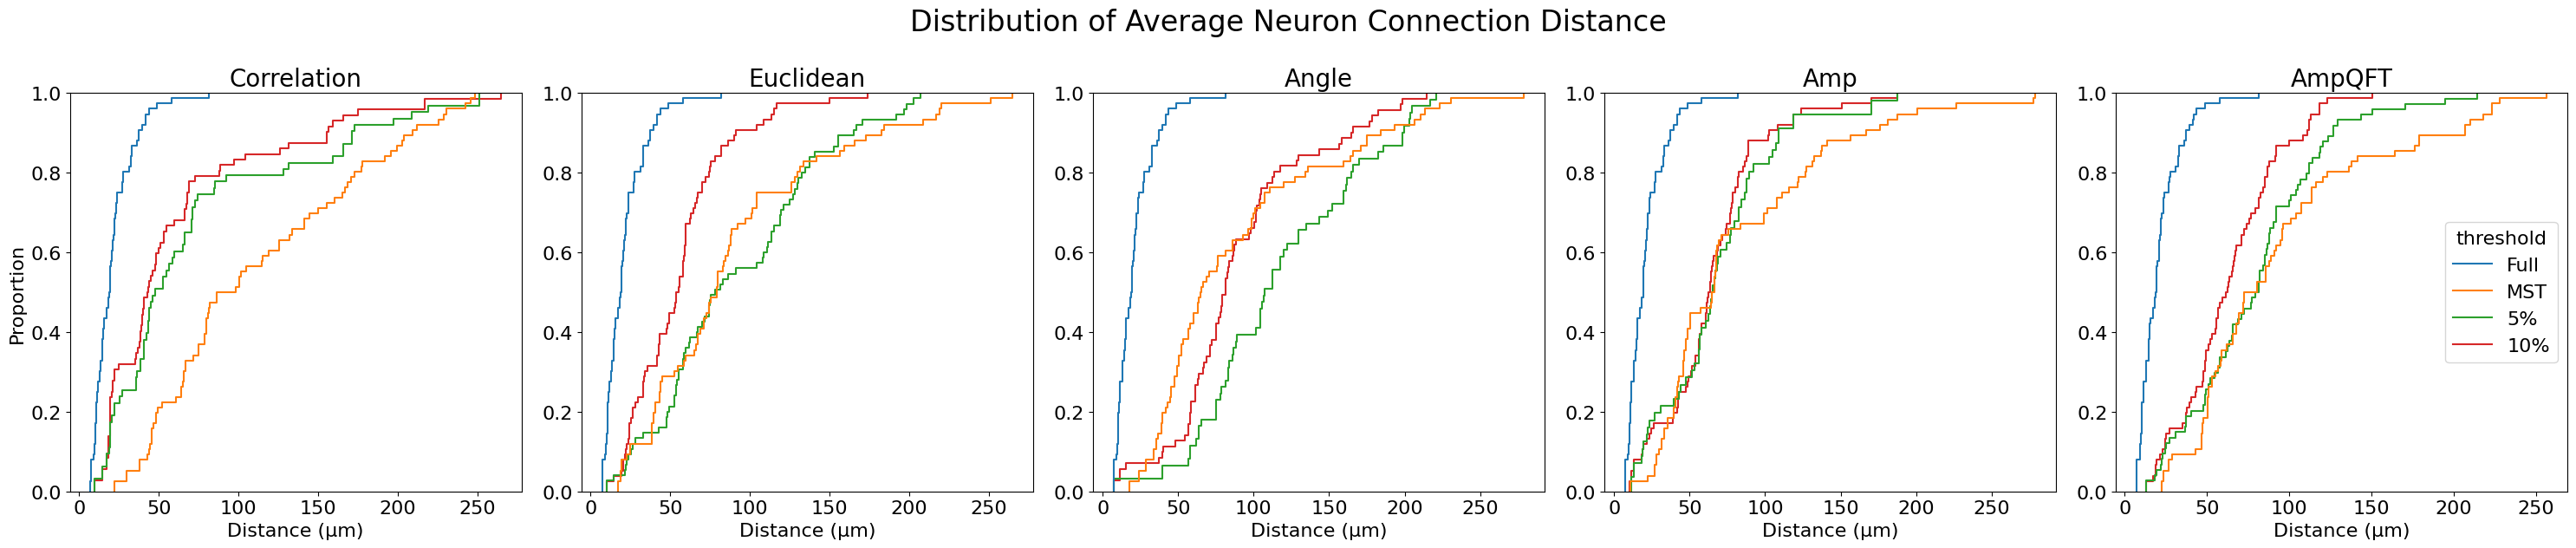

In [283]:
# for threshold in set(distances_calcs_df['threshold']):
plt.close()
metric_names = graph_labels #  set(distances_calcs_df['metric'])
# plt.close()
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(1, len(metric_names), figsize=(len(metric_names)*6, 6.5))

for i, metric in enumerate(metric_names):

    # Plot Distribution of Average Neuronal Connection Distances
    # plt.figure(figsize=(8, 6))
    sns.ecdfplot(distances_calcs_df[distances_calcs_df['metric'] == metric], x='Average distance', hue='threshold', ax=axs[i])

    axs[i].set_title(metric, fontsize=20)
    # plt.xlabel("Average Distance")
    axs[i].set_xlabel("Distance (μm)")
    # axs[i].legend(loc='lower right')

    leg = axs[i].get_legend()
    if i > 0:
        # axs[i].set_yticks([])
    # else:
        axs[i].set_ylabel('')
        
    if i == 4:
        # axs[i].set_ylabel("CDF")
        leg.set_loc('center right') # , bbox_to_anchor=(1, 1))
    else:
        leg.set_visible(False)
        
    # else:
        # axs[i].get_legend().set_visible(False) # hide legend for other subplots
plt.suptitle(f"Distribution of Average Neuron Connection Distance", fontsize=24)
plt.tight_layout() # distances_calcs_df['threshold'])
plt.show()

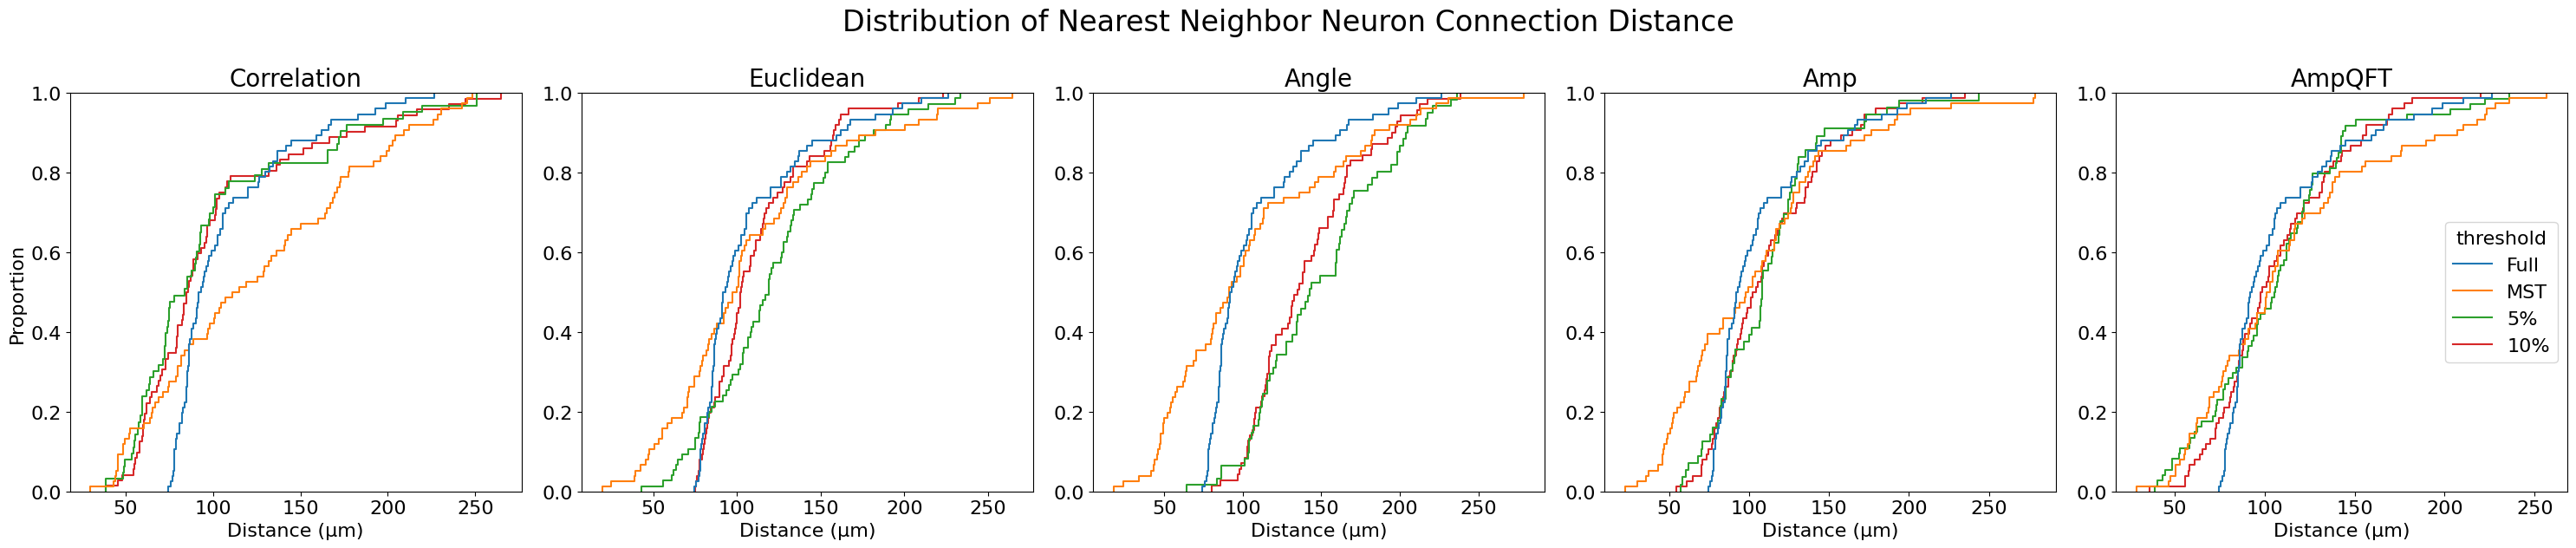

In [284]:
# for threshold in set(distances_calcs_df['threshold']):
plt.close()
metric_names = graph_labels #  set(distances_calcs_df['metric'])
# plt.close()
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(1, len(metric_names), figsize=(len(metric_names)*6, 6.5))

for i, metric in enumerate(metric_names):

    # Plot Distribution of Average Neuronal Connection Distances
    # plt.figure(figsize=(8, 6))
    sns.ecdfplot(distances_calcs_df[distances_calcs_df['metric'] == metric], x='Nearest neighbor distance', hue='threshold', ax=axs[i])

    axs[i].set_title(metric, fontsize=20)
    # plt.xlabel("Average Distance")
    axs[i].set_xlabel("Distance (μm)")
    # axs[i].legend(loc='lower right')

    leg = axs[i].get_legend()
    if i > 0:
        # axs[i].set_yticks([])
    # else:
        axs[i].set_ylabel('')
        
    if i == 4:
        # axs[i].set_ylabel("CDF")
        leg.set_loc('center right') # , bbox_to_anchor=(1, 1))
    else:
        leg.set_visible(False)
        
    # else:
        # axs[i].get_legend().set_visible(False) # hide legend for other subplots
plt.suptitle(f"Distribution of Nearest Neighbor Neuron Connection Distance", fontsize=24)
plt.tight_layout() # distances_calcs_df['threshold'])
plt.show()